# `MEDUSA`
aka. Dynamic-Prospective LCA aka. Union(premise, temporalis)

In [1]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution, easy_datetime_distribution
from bw_temporalis.lcia.climate import characterize_methane, characterize_co2
import sys
import os
sys.path.append(os.path.realpath('../'))
from medusa.edge_extractor import *
from medusa.matrix_modifier import MatrixModifier
from medusa.medusa_lca import *
from medusa.timeline_builder import TimelineBuilder
from medusa.dynamic_characterization import DynamicCharacterization
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd

In [2]:
from tests.databases import *
db_dynamic_cf_test()

100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 1111.07it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 


In [3]:
demand = {('foreground', 'A'): 1}
gwp = ('GWP', 'example')

# Static LCA

In [4]:
slca = bc.LCA(demand, gwp)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 52017.0


# `MEDUSA` LCA

In [5]:
SKIPPABLE = [node.id for node in bd.Database('background_2020')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

Now we can do the graph traversal and create a timeline of edges:

In [6]:
import warnings
warnings.filterwarnings("ignore")

database_date_dict = {
            'background_2008': datetime.strptime("2008", "%Y"),
            'background_2024': datetime.strptime("2024", "%Y"),
            'foreground': "dynamic", # flag databases that should be temporally distributed with "dynamic"
        }

In [7]:
mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=1000)

Starting graph traversal
Calculation count: 3


In [8]:
mlca.build_timeline()

All databases in database_date_dict exist as brightway project databases


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,2024,387,2024-01-01,387,C,2024,393,2024-01-01,391,B,13.0,{'background_2024': 1}
1,2024,393,2024-01-01,391,B,2024,394,2024-01-01,392,A,4.0,{'background_2024': 1}
2,2024,394,2024-01-01,392,A,2024,-1,2024-01-01,-1,-1,1.0,{'background_2024': 1}


In [9]:
mlca.build_datapackage()

In [10]:
mlca.lci()

In [11]:
mlca.lcia()

In [12]:
print('New MEDUSA LCA Score:', mlca.score)
print('Old static LCA Score:', slca.score)

New MEDUSA LCA Score: 52017.0
Old static LCA Score: 52017.0


In [13]:
mlca.build_dynamic_biosphere()

In [14]:
mlca.calculate_dynamic_lci()



In [15]:
mlca.characterize_dynamic_lci({"carbon dioxide": characterize_co2, "methane": characterize_methane})	
mlca.dynamic_inventory_characterizer.dynamic_lci_df 


,date,amount,activity,flow
0,2021-12-31 12:21:36,10400.0,388,385
1,2024-01-01 00:00:00,52000.0,387,385
2,2024-01-01 00:00:00,52000.0,388,385
3,2024-01-01 00:00:00,17.0,394,385
4,2024-12-31 05:49:12,36400.0,388,385
5,2025-12-31 11:38:24,5200.0,388,385
6,2021-12-31 12:21:36,4.0,393,386


In [16]:
mlca.characterized_inventory

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2021-12-31 12:21:36,0.000000e+00,385,carbon dioxide,388,"(background_2024, electricity_wind)",0.000000e+00
1,2022-12-31 18:10:48,1.768417e-11,385,carbon dioxide,388,"(background_2024, electricity_wind)",1.768417e-11
2,2024-01-01 00:00:00,1.660052e-11,385,carbon dioxide,388,"(background_2024, electricity_wind)",3.428469e-11
3,2024-01-01 00:00:00,0.000000e+00,385,carbon dioxide,394,"(foreground, A)",3.428469e-11
4,2024-01-01 00:00:00,0.000000e+00,385,carbon dioxide,388,"(background_2024, electricity_wind)",3.428469e-11
...,...,...,...,...,...,...,...
695,2116-12-31 13:15:36,4.108858e-16,386,methane,393,"(foreground, B)",1.038879e-11
696,2117-12-31 19:04:48,3.790507e-16,386,methane,393,"(foreground, B)",1.038917e-11
697,2119-01-01 00:54:00,3.496823e-16,386,methane,393,"(foreground, B)",1.038952e-11
698,2120-01-01 06:43:12,3.225892e-16,386,methane,393,"(foreground, B)",1.038984e-11


In [28]:
import seaborn as sb
def plot_dynamic_characterized_inventory(self):
    """
    Plot the characterized inventory of the dynamic LCI in a very simple plot
    """

    axes = sb.scatterplot(
        x="date", 
        y="amount",
        hue="activity_name",
        style="flow_name",
        data=self.characterized_inventory
    )
    
    
    axes.set_ylabel("GWP in W/m2")
    axes.set_xlabel("Time (years)")
    
    axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

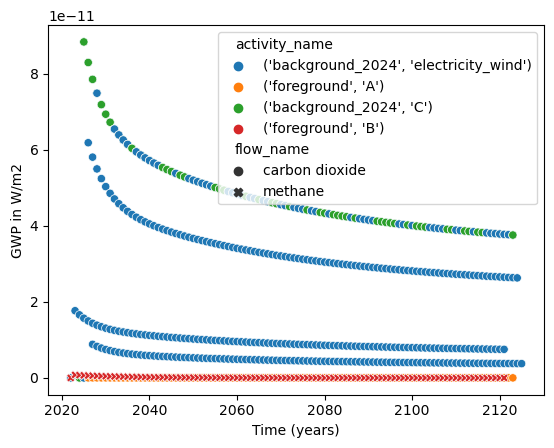

In [29]:
plot_dynamic_characterized_inventory(mlca)

In [21]:
    dfs = []

    for database in bd.databases:
        df1 = bd.Database(database).nodes_to_dataframe()
        dfs.append(df1)

    all_databases_df = pd.concat(dfs, ignore_index=True)
    print(all_databases_df)

               code         database   id                          name  \
0               CO2   temporalis-bio  385                carbon dioxide   
1               CH4   temporalis-bio  386                       methane   
2                 C  background_2024  387                             C   
3  electricity_wind  background_2024  388  Electricity production, wind   
4                 C  background_2008  389                             C   
5  electricity_wind  background_2008  390  Electricity production, wind   
6                 A       foreground  392                             A   
7                 B       foreground  391                             B   

  temporalis code      type   location  reference product  
0             co2  emission        NaN                NaN  
1             ch4  emission        NaN                NaN  
2             NaN       NaN  somewhere                  c  
3             NaN       NaN  somewhere  electricity, wind  
4             NaN       

In [22]:
print(mlca.characterized_inventory)
print("-------------------")
print(all_databases_df)
print("-------------------")
data= mlca.characterized_inventory.merge(
            all_databases_df.rename(columns={'id': 'activity'}), 
            on='activity')
print(data)
print(len(data))
print(len(mlca.characterized_inventory))

                   date        amount  flow       flow_name  activity  \
0   2021-12-31 12:21:36  0.000000e+00   385  carbon dioxide       388   
1   2022-12-31 18:10:48  1.768417e-11   385  carbon dioxide       388   
2   2024-01-01 00:00:00  1.660052e-11   385  carbon dioxide       388   
3   2024-01-01 00:00:00  0.000000e+00   385  carbon dioxide       394   
4   2024-01-01 00:00:00  0.000000e+00   385  carbon dioxide       388   
..                  ...           ...   ...             ...       ...   
695 2116-12-31 13:15:36  4.108858e-16   386         methane       393   
696 2117-12-31 19:04:48  3.790507e-16   386         methane       393   
697 2119-01-01 00:54:00  3.496823e-16   386         methane       393   
698 2120-01-01 06:43:12  3.225892e-16   386         methane       393   
699 2120-12-31 12:32:24  2.975953e-16   386         methane       393   

                           activity_name    amount_sum  
0    (background_2024, electricity_wind)  0.000000e+00  
1    (bac

In [23]:
mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=1000)
mlca.build_timeline()
mlca.build_datapackage()
mlca.lci()
mlca.lcia()

mlca.build_dynamic_biosphere()
mlca.calculate_dynamic_lci()
mlca.characterize_dynamic_lci({"carbon dioxide": characterize_co2, "methane": characterize_methane})

Starting graph traversal
Calculation count: 3
All databases in database_date_dict exist as brightway project databases


TODO make sure all arguments can be passed, e.g. cumsum. switch between methane and CO2,
 addition of methane and CO2, selected timeframe, add units, add plotting, add ids sum needs to be the same as for temporalis example